<h1><center><font size=10>Introduction to LLMs and GenAI</center></font></h1>
<h1><center>Capstone Project 1 : AI-Powered Stock News Sentiment & Summarization System</center></h1>

## Context

Stock prices are influenced by company performance, innovations, collaborations, and market sentiment. Rapidly emerging news and media reports can significantly sway investor perceptions, making it challenging for analysts to keep up with the volume of information. Investment firms need AI tools to quickly assess market sentiment and integrate insights into trading strategies.

### Objective

To develop an AI system that:

- Analyzes historical financial news to determine market sentiment toward a NASDAQ-listed company.

- Generates weekly sentiment summaries of the news.

- Correlates sentiment trends with stock price movements (Open, High, Low, Close, Volume).

- Provides analysts with actionable insights for trading and investment decisions.

### Data Dictionary

- Date: The date the news was released

- News: The content of news articles that could potentially affect the company's stock price

- Open: The stock price (in $) at the beginning of the day

- High: The highest stock price (in $) reached during the day

- Low: The lowest stock price (in $) reached during the day

- Close: The adjusted stock price (in $) at the end of the day

- Volume: The number of shares traded during the day

- Label: The sentiment polarity of the news content
	 -  1: Positive
	 -  0: Neutral
	 -  -1: Negative


##Setup & Install Libraries

In [ ]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn plotly
!pip install sentence-transformers
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install tqdm

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import torch


##Load & Inspect Data

In [ ]:
# Load your dataset (CSV with Date, News, Open, High, Low, Close, Volume, Label)
df = pd.read_csv("/content/drive/MyDrive/Intro to LLM and Gen AI/stock_news.csv")

# Inspect the first few rows
df.head()


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
# Check data info
df.info()

# Check missing values
df.isnull().sum()

# Parse date column to datetime
df['Date'] = pd.to_datetime(df['Date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


##Text Preprocessing

In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)          # remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    return text

# Apply preprocessing
df['clean_news'] = df['News'].apply(clean_text)

# Preview
df[['News', 'clean_news']].head()


,News,clean_news
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on longd...
4,Apple's revenue warning led to a decline in U...,apples revenue warning led to a decline in usd...


##Generate Embeddings for News

In [ ]:
# Load pre-trained Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
news_embeddings = model.encode(df['clean_news'].tolist(), batch_size=32, show_progress_bar=True)

# Convert embeddings to numpy array
news_embeddings = np.array(news_embeddings)
print("Embeddings shape:", news_embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Embeddings shape: (349, 384)


##Sentiment Analysis Using Labels / LLM

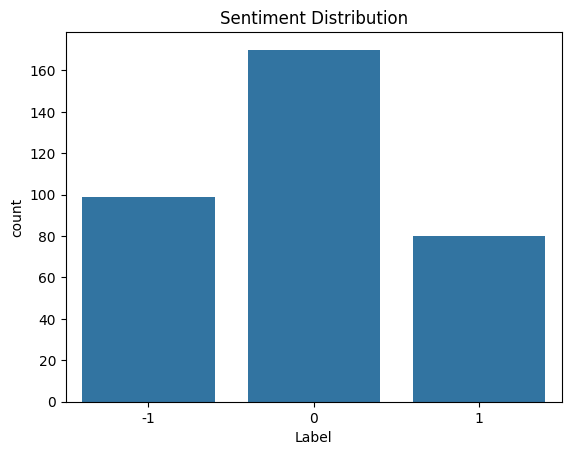

In [ ]:
# Check distribution
sns.countplot(x='Label', data=df)
plt.title("Sentiment Distribution")
plt.show()


##Weekly Sentiment Aggregation

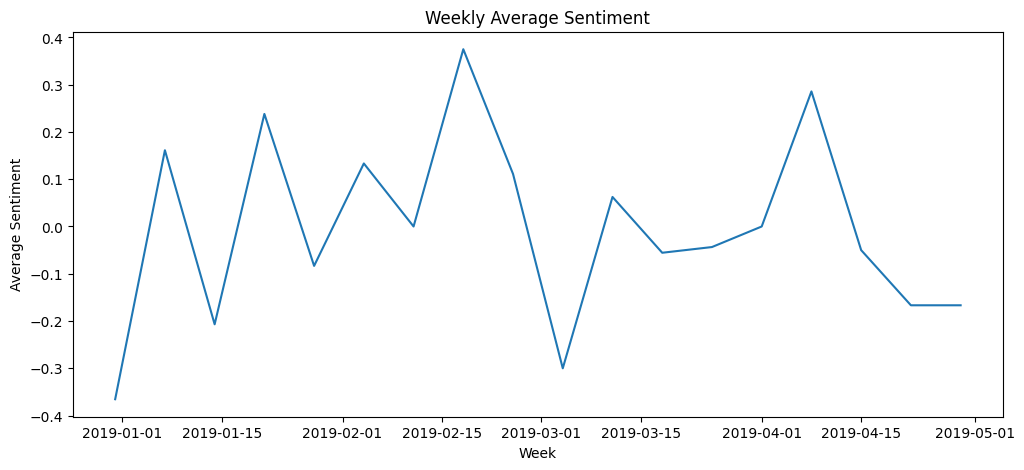

In [ ]:
# Create a week column
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate weekly sentiment
weekly_sentiment = df.groupby('Week')['Label'].mean().reset_index()
weekly_sentiment.head()

# Plot weekly sentiment
plt.figure(figsize=(12,5))
sns.lineplot(x='Week', y='Label', data=weekly_sentiment)
plt.title("Weekly Average Sentiment")
plt.xlabel("Week")
plt.ylabel("Average Sentiment")
plt.show()


##Weekly Stock Summary

In [ ]:
# Aggregate weekly stock data
weekly_stock = df.groupby('Week').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

# Merge sentiment and stock
weekly_data = weekly_stock.merge(weekly_sentiment, on='Week')
weekly_data.head()


,Week,Open,High,Low,Close,Volume,Label
0,2018-12-31,41.740002,47.919998,41.482498,46.419842,5843148000,-0.365385
1,2019-01-07,50.792500,63.982498,50.162498,62.571354,4776854800,0.161290
2,2019-01-14,37.712502,39.470001,37.305000,37.902481,3561556800,-0.206897
3,2019-01-21,39.102501,39.532501,37.924999,38.129673,2386096000,0.238095
4,2019-01-28,38.947498,42.250000,38.415001,38.168350,7005030800,-0.083333


##Correlation Analysis

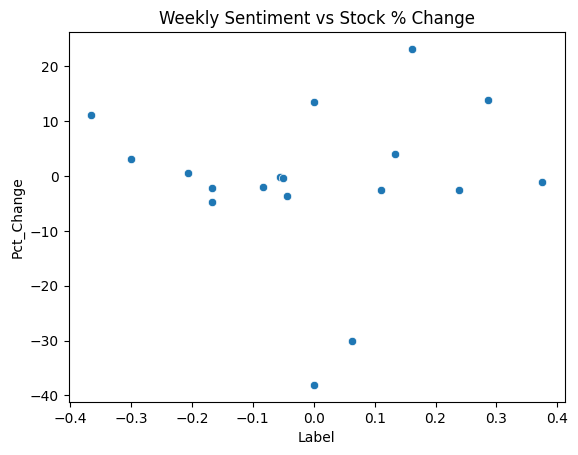

Correlation between sentiment and stock % change: 0.03


In [ ]:
# Compute correlation between sentiment and stock movement
weekly_data['Pct_Change'] = (weekly_data['Close'] - weekly_data['Open']) / weekly_data['Open'] * 100

# Plot correlation
sns.scatterplot(x='Label', y='Pct_Change', data=weekly_data)
plt.title("Weekly Sentiment vs Stock % Change")
plt.show()

# Correlation coefficient
corr = weekly_data['Label'].corr(weekly_data['Pct_Change'])
print(f"Correlation between sentiment and stock % change: {corr:.2f}")


##Weekly News Summarization (LLM)

In [ ]:
from transformers import pipeline

# Load summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Example: summarize all news in a week
def summarize_weekly_news(week):
    texts = df[df['Week'] == week]['clean_news'].tolist()
    if len(texts) == 0:
        return ""
    combined_text = " ".join(texts)[:2000]  # limit to 2000 chars for model
    summary = summarizer(combined_text, max_length=100, min_length=40, do_sample=False)
    return summary[0]['summary_text']

# Add summary column
weekly_data['Weekly_Summary'] = weekly_data['Week'].apply(summarize_weekly_news)
weekly_data[['Week','Weekly_Summary']].head()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Week,Weekly_Summary
0,2018-12-31,Apple lowered its fiscal q1 revenue guidance t...
1,2019-01-07,Amazons stock is predicted to surge by over 20...
2,2019-01-14,The us stock market declined on monday as conc...
3,2019-01-21,Swiss national bank governor andrea maechler s...
4,2019-01-28,Caterpillar inc reported lowerthanexpected fou...


##Generate Automated Actionable Insights

In [ ]:
# Define a function to generate insights
def generate_insights(row):
    insights = []

    # Positive sentiment followed by price rise
    if row['Label'] > 0 and row['Pct_Change'] > 0:
        insights.append(f"Positive news sentiment ({row['Label']:.2f}) preceded a price increase of {row['Pct_Change']:.2f}%")

    # Negative sentiment followed by price drop
    if row['Label'] < 0 and row['Pct_Change'] < 0:
        insights.append(f"Negative news sentiment ({row['Label']:.2f}) preceded a price decrease of {row['Pct_Change']:.2f}%")

    # Neutral sentiment
    if row['Label'] == 0:
        insights.append("Neutral sentiment observed this week; minimal price impact")

    # Large price change with low sentiment
    if abs(row['Pct_Change']) > 5 and abs(row['Label']) < 0.3:
        insights.append(f"Stock moved {row['Pct_Change']:.2f}% despite neutral sentiment; investigate external factors")

    return insights

# Apply to weekly data
weekly_data['Insights'] = weekly_data.apply(generate_insights, axis=1)
weekly_data[['Week', 'Label', 'Pct_Change', 'Insights']].head(10)


,Week,Label,Pct_Change,Insights
0,2018-12-31,-0.365385,11.211883,[]
1,2019-01-07,0.161290,23.190144,[Positive news sentiment (0.16) preceded a pri...
2,2019-01-14,-0.206897,0.503756,[]
3,2019-01-21,0.238095,-2.487892,[]
4,2019-01-28,-0.083333,-2.000508,[Negative news sentiment (-0.08) preceded a pr...
5,2019-02-04,0.133333,4.061215,[Positive news sentiment (0.13) preceded a pri...
6,2019-02-11,0.000000,-38.090807,[Neutral sentiment observed this week; minimal...
7,2019-02-18,0.375000,-1.042654,[]
8,2019-02-25,0.111111,-2.511883,[]
9,2019-03-04,-0.300000,3.094806,[]


##Interactive Visualizations with Plotly

In [ ]:
#Weekly Sentiment vs Stock Price
import plotly.express as px

fig = px.line(
    weekly_data, x='Week', y=['Label', 'Close'],
    title="Weekly Sentiment vs Stock Close Price",
    labels={'value':'Score / Price', 'Week':'Week'},
)
fig.update_layout(yaxis_title="Sentiment / Close Price")
fig.show()


In [ ]:
#Scatter Plot: Sentiment vs % Change
fig = px.scatter(
    weekly_data, x='Label', y='Pct_Change',
    text='Week', size='Volume',
    color='Label', color_continuous_scale='RdYlGn',
    title="Weekly Sentiment vs Stock % Change",
    labels={'Label':'Avg Sentiment', 'Pct_Change':'Stock % Change'}
)
fig.show()


In [ ]:
#Weekly News Summary Dashboard
for idx, row in weekly_data.iterrows():
    print(f"Week: {row['Week'].date()}")
    print(f"Avg Sentiment: {row['Label']:.2f} | % Change: {row['Pct_Change']:.2f}%")
    print(f"Weekly Summary: {row['Weekly_Summary']}")
    if row['Insights']:
        print("Insights:")
        for insight in row['Insights']:
            print(f"- {insight}")
    print("-"*80)


Week: 2018-12-31
Avg Sentiment: -0.37 | % Change: 11.21%
Weekly Summary: Apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 8993 billion due to weaker than expected iphone sales. The announcement caused a significant drop in apples stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10.
--------------------------------------------------------------------------------
Week: 2019-01-07
Avg Sentiment: 0.16 | % Change: 23.19%
Weekly Summary: Amazons stock is predicted to surge by over 20 by the end of this year according to a new report from pivotal research senior analyst brian wieser initiated coverage on the stock with a buy rating and a yearend price target of 1920 the growth potential for amazon lies primarily in ams an austrian sensor specialist is partnering with chinese software maker face to develop new 3d facial recognition features for smartphones. sprint and samsung plan to rel

##LLM-Powered Analyst Recommendations

In [ ]:
# Install required libraries (if not already installed)
!pip install transformers torch sentence-transformers tqdm

# Import libraries
import torch
from transformers import pipeline
from tqdm import tqdm

# Make sure GPU is used
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")


Using device: GPU


###Load the GPT-Neo Model

In [ ]:
# Load EleutherAI GPT-Neo 2.7B text-generation pipeline
llm = pipeline(
    "text-generation",
    model="EleutherAI/gpt-neo-2.7B",
    device=device,
    tokenizer="EleutherAI/gpt-neo-2.7B"
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
#Define LLM Insight Generation Function
def llm_generate_insights(row):
    """
    Generates actionable analyst insights using GPT-Neo 2.7B
    Input: row from weekly_data containing 'Weekly_Summary', 'Label', 'Pct_Change'
    Output: List of actionable insights
    """

    prompt = f"""
    You are a financial analyst.
    Based on the following information, generate 2-3 concise, actionable insights for investors.

    Weekly Summary: {row['Weekly_Summary']}
    Average Sentiment Score: {row['Label']:.2f}  (1=Positive, 0=Neutral, -1=Negative)
    Stock % Change: {row['Pct_Change']:.2f}%

    Provide insights in bullet points.
    """

    # Generate text using the model
    output = llm(prompt, max_length=200, do_sample=True, temperature=0.7)

    # Extract generated text
    generated_text = output[0]['generated_text']

    # Optional: clean the text by splitting into bullet points
    insights = [line.strip("-• \n") for line in generated_text.split("\n") if len(line.strip())>0]

    return insights


In [ ]:
from tqdm import tqdm

# Make sure the column exists first
weekly_data['LLM_Insights'] = None

# Apply LLM generation for first 5 weeks (demo)
for idx, row in tqdm(weekly_data.head(5).iterrows(), total=5):
    weekly_data.at[idx, 'LLM_Insights'] = llm_generate_insights(row)

# Preview results
weekly_data[['Week', 'Weekly_Summary', 'Label', 'Pct_Change', 'LLM_Insights']].head()


  0%|          | 0/5 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
 20%|██        | 1/5 [00:21<01:24, 21.15s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
 40%|████      | 2/5 [00:46<01:11, 23.69s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more 

,Week,Weekly_Summary,Label,Pct_Change,LLM_Insights
0,2018-12-31,Apple lowered its fiscal q1 revenue guidance t...,-0.365385,11.211883,"[You are a financial analyst., Based on the fo..."
1,2019-01-07,Amazons stock is predicted to surge by over 20...,0.161290,23.190144,"[You are a financial analyst., Based on the fo..."
2,2019-01-14,The us stock market declined on monday as conc...,-0.206897,0.503756,"[You are a financial analyst., Based on the fo..."
3,2019-01-21,Swiss national bank governor andrea maechler s...,0.238095,-2.487892,"[You are a financial analyst., Based on the fo..."
4,2019-01-28,Caterpillar inc reported lowerthanexpected fou...,-0.083333,-2.000508,"[You are a financial analyst., Based on the fo..."


In [ ]:
#Display LLM-Powered Insights Nicely
for idx, row in weekly_data.head(5).iterrows():
    print(f"Week: {row['Week'].date()}")
    print(f"Average Sentiment: {row['Label']:.2f} | % Change: {row['Pct_Change']:.2f}%")
    print(f"Weekly Summary: {row['Weekly_Summary']}")
    if row['LLM_Insights']:
        print("LLM Insights:")
        for insight in row['LLM_Insights']:
            print(f"- {insight}")
    print("-"*80)


Week: 2018-12-31
Average Sentiment: -0.37 | % Change: 11.21%
Weekly Summary: Apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 8993 billion due to weaker than expected iphone sales. The announcement caused a significant drop in apples stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10.
LLM Insights:
- You are a financial analyst.
- Based on the following information, generate 2-3 concise, actionable insights for investors.
- Weekly Summary: Apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 8993 billion due to weaker than expected iphone sales. The announcement caused a significant drop in apples stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10.
- Average Sentiment Score: -0.37  (1=Positive, 0=Neutral, -1=Negative)
- Stock % Change: 11.21%
- Provide insights in bullet poin

##Interactive Filters with Plotly & Widgets

In [ ]:
!pip install ipywidgets
from ipywidgets import widgets
from IPython.display import display

# Date range slider
start_date = weekly_data['Week'].min()
end_date = weekly_data['Week'].max()

date_range = widgets.SelectionRangeSlider(
    options=weekly_data['Week'],
    index=(0, len(weekly_data)-1),
    description='Select Weeks',
    orientation='horizontal',
    layout={'width':'800px'}
)

display(date_range)

# Function to update chart
def update_chart(change):
    selected_weeks = change['new']
    filtered_data = weekly_data[(weekly_data['Week'] >= selected_weeks[0]) &
                                (weekly_data['Week'] <= selected_weeks[1])]

    fig = px.line(filtered_data, x='Week', y=['Label','Close'],
                  title="Weekly Sentiment vs Stock Close Price")
    fig.show()

date_range.observe(update_chart, names='value')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


SelectionRangeSlider(description='Select Weeks', index=(0, 17), layout=Layout(width='800px'), options=(Timesta…

##Export Reports (CSV/PDF)

In [ ]:
# Save weekly data with insights
weekly_data.to_csv("weekly_stock_insights.csv", index=False)
print("CSV report saved!")


CSV report saved!


In [ ]:
!pip install fpdf
from fpdf import FPDF

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

for idx, row in weekly_data.iterrows():
    pdf.multi_cell(0, 8, f"Week: {row['Week'].date()}")
    pdf.multi_cell(0, 8, f"Avg Sentiment: {row['Label']:.2f} | % Change: {row['Pct_Change']:.2f}%")
    pdf.multi_cell(0, 8, f"Weekly Summary: {row['Weekly_Summary']}")

    # Handle LLM_Insights as a list
    if 'LLM_Insights' in row and row['LLM_Insights']:
        pdf.multi_cell(0, 8, "LLM Insights:")
        # Join list into a single string with newlines
        insights_text = "\n".join(row['LLM_Insights'])
        pdf.multi_cell(0, 8, insights_text)

    pdf.multi_cell(0, 8, "-"*80)

pdf.output("Weekly_Stock_Insights.pdf")
print("PDF report saved!")


PDF report saved!
